In [1]:
from collections import defaultdict, deque
import matplotlib.pyplot as plt
from time import time

# 1. Zaimplementuj algorytm wyszukiwania wzorca 2-wymiarowego

#### Wyszukiwanie wzorca 1D (budowa automatu w czasie liniowym względem długości wzorca)

In [2]:
def transition_table(pattern):
    n = len(pattern)
    alphabet = set(pattern)
    transition = [defaultdict(lambda: 0) for _ in range(n + 1)]

    for i, pattern_letter in enumerate(pattern):
        prev = transition[i][pattern_letter]
        transition[i][pattern_letter] = i + 1
        for alphabet_letter in alphabet:
            transition[i + 1][alphabet_letter] = transition[prev][alphabet_letter]

    return transition


def automaton_pattern_matching(text, transition_tab):
    result = []

    q = 0
    m = len(transition_tab) - 1
    for i in range(0, len(text)):
        if text[i] in transition_tab[q]:
            q = transition_tab[q][text[i]]
            if q == m:
                result.append(i + 1 - q)
        else:
            q = 0

    return result

#### Implementacja budowy drzewa trie oraz funkcji zwracającej tablicę przejścia i stany akceptujące dla automatu wykrywającego wiele wzorców

In [14]:
class TrieNode:
    def __init__(self, node_id, letter="", parent=None):
        self.id = node_id
        self.letter = letter
        self.parent = parent
        self.terminal = False
        self.children = dict()

    def __str__(self):
        return f"TrieNode: letter={self.letter}, id={self.id}, terminal={self.terminal}, "
               f"children={[(children.letter, children.id) for children in self.children.values()]}, "
               f"parent_letter={self.parent.letter if self.parent is not None else 'NONE'}"


def build_trie(patterns):
    node_id = 0
    root = TrieNode(node_id, "root")
    nodes = [root]

    for pattern in patterns:
        node = root
        for letter in pattern:
            if letter in node.children:
                node = node.children[letter]
            else:
                node_id += 1
                new_node = TrieNode(node_id, letter, node)
                nodes.append(new_node)
                node.children[letter] = new_node
                node = new_node

        node.terminal = True

    return root, nodes


def print_trie(node):
    print(node)
    for children in node.children.values():
        print_trie(children)


def multi_patterns_transition_table(patterns, trie_print=False):
    trie, nodes = build_trie(patterns)

    alphabet = set()
    for pattern in patterns:
        alphabet.update(pattern)

    transition = [defaultdict(lambda: 0) for _ in range(len(nodes))]
    accept_states = []

    queue = deque(trie.children.values())
    while len(queue) > 0:
        node = queue.popleft()
        queue.extend(node.children.values())

        prev = transition[node.parent.id][node.letter]
        prev_node = nodes[prev]
        transition[node.parent.id][node.letter] = node.id

        if node.terminal or prev_node.terminal:
            accept_states.append(node.id)

        for letter in alphabet:
            if letter in prev_node.children:
                transition[node.id][letter] = prev_node.children[letter].id
            else:
                transition[node.id][letter] = transition[prev][letter]

    if trie_print:
        print_trie(trie)

    return transition, accept_states

#### Implementacja algorytmuu wyszukiwania wzorca 2-wymiarowego

In [15]:
def pattern_matching_2D(text, pattern_2d, split_lines=False, print_times=False):
    if split_lines:
        text = text.split("\n")

    patterns = [[] for _ in range(len(pattern_2d[0]))]
    for row in pattern_2d:
        for i, letter in enumerate(row):
            patterns[i].append(letter)

    start = time()
    transition, accept_states = multi_patterns_transition_table(patterns)
    if print_times:
        print(f"Czas budowy tablicy przejścia automatu: {round(time() - start, 4)} sek.")

    row_pattern = []
    for pattern in patterns:
        state = 0
        for letter in pattern:
            state = transition[state][letter]
        row_pattern.append(state)

    start = time()
    width, height = len(max(text, key=len)), len(text)
    states = [[0 for _ in range(len(line))] for line in text]

    for col in range(width):
        state = 0
        for row in range(height):
            if col < len(text[row]):
                letter = text[row][col]
                state = transition[state][letter]
                states[row][col] = state
            else:
                state = 0

    # [print(x) for x in states]
    result = []
    pattern_height = len(pattern_2d)
    row_pattern_transition = transition_table(row_pattern)
    for i, row in enumerate(states):
        result += [(i - pattern_height + 1, x) for x in automaton_pattern_matching(row, row_pattern_transition)]

    if print_times:
        print(f"Czas wyszukiwania wzorców: {round(time() - start, 4)} sek.")

    return result

#### Przykład działania dla prostych przypadków

In [26]:
multi_transition_tab, accept = multi_patterns_transition_table(["ab", "babb", "bb"])
print("=====[ Budowa automatu dla wielu wzorców ]=====")
print("WZORCE: \"ab\", \"babb\", \"bb\"")
print("Tablica przejścia dla wielu wzorców:")
[print(f"{i}: {dict(x)}") for i, x in enumerate(multi_transition_tab)]
print("Stany akceptujące:")
print(accept, end="\n\n")

res = pattern_matching_2D("abababb\naaaabbb\nbbbaaab\naaabbaa\nbbaaabb\naabaaaa", ["aaa", "bba", "aab"],
                          split_lines=True)
print("=====[ Wyszukiwanie wzorca 2D ]=====")
print("TEKST: \nabababb\naaaabbb\nbbbaaab\naaabbaa\nbbaaabb\naabaaaa")
print("WZORZEC: \naaa\nbba\naab")
print("Znaleziono dopasowanie wzorca na pozycjach:")
[print(f" -> wiersz: {row}, kolumna: {col}") for row, col in res]

=====[ Budowa automatu dla wielu wzorców ]=====
WZORCE: "ab", "babb", "bb"
Tablica przejścia dla wielu wzorców:
0: {'a': 1, 'b': 3}
1: {'b': 2, 'a': 1}
2: {'b': 7, 'a': 4}
3: {'b': 7, 'a': 4}
4: {'b': 5, 'a': 1}
5: {'b': 6, 'a': 4}
6: {'b': 7, 'a': 4}
7: {'b': 7, 'a': 4}
Stany akceptujące:
[2, 7, 5, 6]

=====[ Wyszukiwanie wzorca 2D ]=====
TEKST: 
abababb
aaaabbb
bbbaaab
aaabbaa
bbaaabb
aabaaaa
WZORZEC: 
aaa
bba
aab
Znaleziono dopasowanie wzorca na pozycjach:
 -> wiersz: 1, kolumna: 1
 -> wiersz: 2, kolumna: 3
 -> wiersz: 3, kolumna: 0


[None, None, None]

In [28]:
with open("haystack.txt") as file:
    haystack_text = file.read()

    res = pattern_matching_2D(haystack_text, ["t h", "t h"], split_lines=True, print_times=True)
    print(res)

Czas budowy tablicy przejścia automatu: 0.0 sek.
Czas wyszukiwania wzorców: 0.002 sek.
[(37, 0)]


In [6]:
# from time import time
#
# def time_function(func, text):
#     def timed_function(*args):
#         start = time()
#         result = func(*args)
#         print(f"{text}: {time() - start}")
#         return result
#
#     return timed_function
#
# text_ = "qwertyuiopasdfghjklzxcvbnm" * 1000
# pattern_ = "qwertyuiop" * 100
#
# timed_transition_table = time_function(transition_table, "Transition table build time")
# timed_automaton_string_matching = time_function(automaton_pattern_matching, "String matching time")
#
# trans_tab = timed_transition_table(pattern_)
# timed_automaton_string_matching(text_, trans_tab)

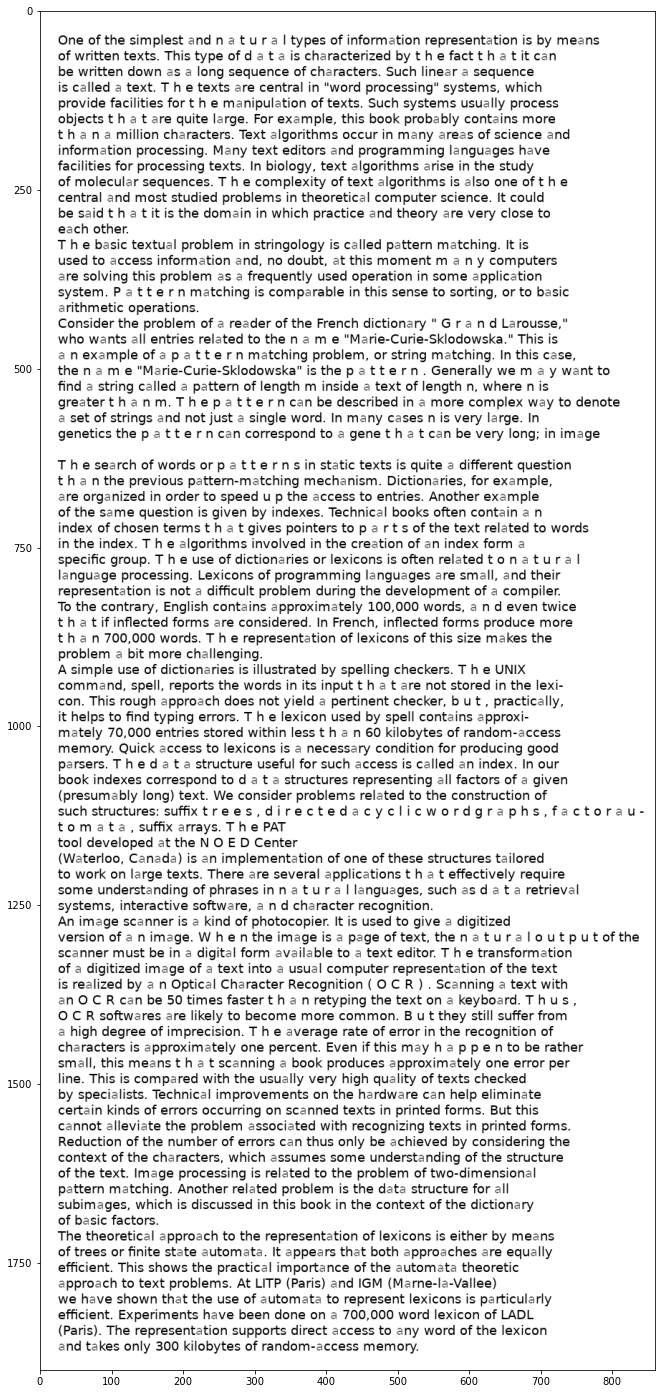

In [67]:
import imageio

img = imageio.imread("haystack.png")
img = [[x[0] for x in im_row] for im_row in img]

a = [im_row[302:313] for im_row in img[58:70]]

# plt.figure(figsize=(3, 3))
# plt.imshow(a, cmap='gray')
# plt.show()

results = pattern_matching_2D(img, a)
# print(results)
for row, col in results:
    for i in range(len(a)):
        for j in range(len(a[0])):
            img[row + i][col + j] = 100
            img[row + i][col + j] = min(img[row + i][col + j], 255)

plt.figure(figsize=(25, 25))
plt.imshow(img, cmap='gray')
plt.show()